# LSTM Model

## Libary

In [70]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model
import pandas as pd

## Hyperparameters

In [50]:
# DATA
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (30, 1086)
NUM_CLASSES = 40

# DATA PATH
LSTM_DATASET_PATH = "LSTM_DATASET"

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 200

# Data

## Load the data

In [107]:
# List to store the data and labels
data = []
labels = []

# List all class folders in the new dataset directory
class_folders = os.listdir(LSTM_DATASET_PATH)

# Loop through each class folder
for class_folder in class_folders:
    class_dir = os.path.join(LSTM_DATASET_PATH, class_folder)

    # Get the list of numpy files in the class folder
    numpy_files = [file for file in os.listdir(class_dir) if file.endswith(".npy")]

    for numpy_file in numpy_files:
        # Load the numpy array
        frames = np.load(os.path.join(class_dir, numpy_file))

        # Append the data and corresponding label
        data.append(frames)
        labels.append(class_folder)  # Assuming the folder name is the class label

# Convert the lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [108]:
data.shape

(1200, 30, 1086)

## Process the data

In [109]:
print(data[0][0])
print(data[0][0][0::2][0:2])
print(data[0][0][1::2][0:2])

[0.58055061 0.44744369 0.59845448 ... 0.41793156 0.62705356 0.41525495]
[0.58055061 0.59845448]
[0.44744369 0.40675837]


In [110]:
for frames in data:
    for frame in frames:
        frame_x = frame[1::2]
        max_x = np.max(frame_x)
        min_x = np.min(frame_x)
        for index in range(len(frame_x)):
            if frame_x[index] != 0: frame_x[index] /= (max_x - min_x)

        frame_y = frame[0::2]
        max_y = np.max(frame_y)
        min_y = np.min(frame_y)
        for index in range(len(frame_y)):
            if frame_y[index] != 0: frame_y[index] /= (max_y - min_y)
        
        

In [112]:
# Label encode the class labels
unique_labels = np.unique(labels)
label_to_index = {label: i for i, label in enumerate(unique_labels)}

# Convert class labels to corresponding indices
label_indices = np.array([label_to_index[label] for label in labels])

# Split the data into training, validation, and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data, label_indices, test_size=0.2, shuffle = True, random_state=42, stratify=label_indices)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, shuffle = True, random_state=42, stratify=temp_labels)

## Check the data

In [113]:
print("Train data")
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print("\n")

print("Validation data")
print(f"Validation data shape: {valid_data.shape}")
print(f"Validation labels shape: {valid_labels.shape}")
print("\n")

print("Test data")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train data
Train data shape: (960, 30, 1086)
Train labels shape: (960,)


Validation data
Validation data shape: (120, 30, 1086)
Validation labels shape: (120,)


Test data
Test data shape: (120, 30, 1086)
Test labels shape: (120,)


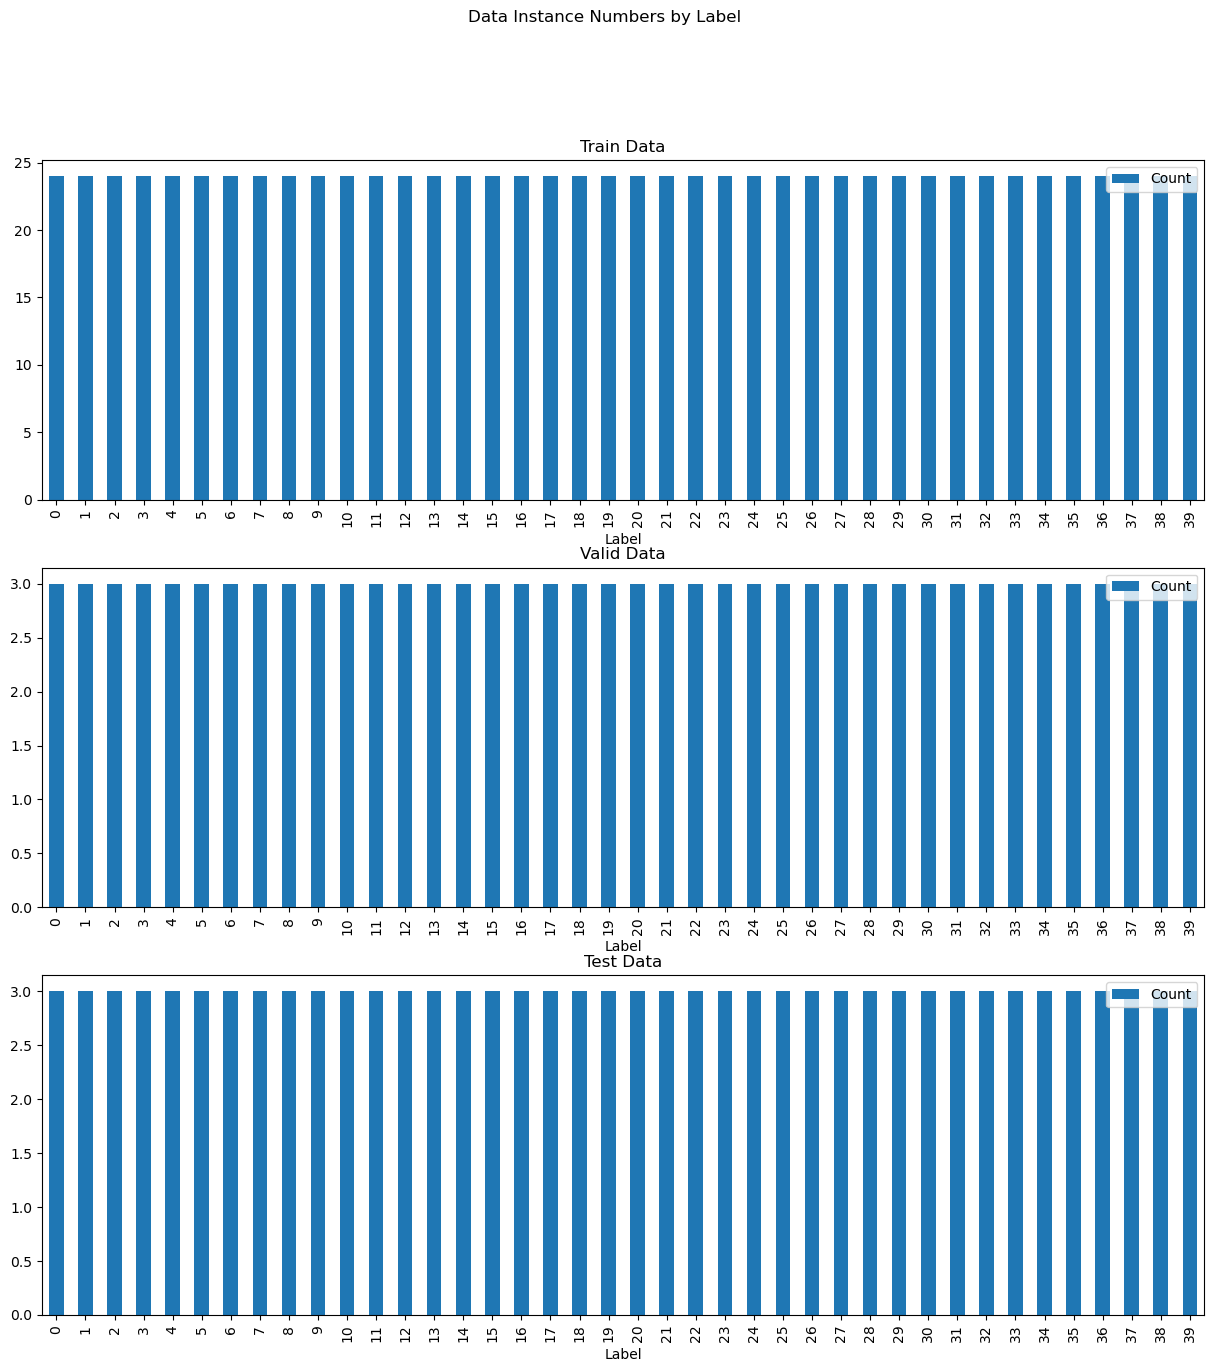

In [114]:
# Calculate label counts
train_label_counts = np.unique(train_labels, return_counts=True)
valid_label_counts = np.unique(valid_labels, return_counts=True)
test_label_counts = np.unique(test_labels, return_counts=True)

# Create DataFrames
train_df = pd.DataFrame({'Label': train_label_counts[0], 'Count': train_label_counts[1]})
valid_df = pd.DataFrame({'Label': valid_label_counts[0], 'Count': valid_label_counts[1]})
test_df = pd.DataFrame({'Label': test_label_counts[0], 'Count': test_label_counts[1]})

# Create subplots for each dataset
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# Plot bar charts for each dataset
train_df.plot(kind='bar', x='Label', y='Count', ax=axes[0], title='Train Data')
valid_df.plot(kind='bar', x='Label', y='Count', ax=axes[1], title='Valid Data')
test_df.plot(kind='bar', x='Label', y='Count', ax=axes[2], title='Test Data')

# Set labels and title for the whole figure
fig.suptitle('Data Instance Numbers by Label')
plt.show()

# Model

## Create the model

In [115]:
# Define the L2 regularization strength
# l2_strength = 0.001
# kernel_regularizer=tf.keras.regularizers.l2(l2_strength)
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), input_shape=INPUT_SHAPE),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Update the optimizer to Adam
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

## Train the model

In [116]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20, verbose=1)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(train_data, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(valid_data, valid_labels), callbacks=[lr_scheduler, early_stopping])

Epoch 1/200


2023-08-26 16:09:08.364747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:08.897975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:08.978264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:09.277742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:09.308232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:09.894914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:09.925163: I tensorflow/core/grappler/optimizers/cust

30/30 [==============================] - ETA: 0s - loss: 4.1928 - accuracy: 0.0344

2023-08-26 16:09:13.424180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:13.591097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:13.604524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:13.732496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 16:09:13.745794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 8s 124ms/step - loss: 4.1928 - accuracy: 0.0344 - val_loss: 3.6555 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 2/200
30/30 [==============================] - 1s 49ms/step - loss: 3.7807 - accuracy: 0.0625 - val_loss: 3.4687 - val_accuracy: 0.0667 - lr: 1.0000e-04
Epoch 3/200
30/30 [==============================] - 1s 46ms/step - loss: 3.5425 - accuracy: 0.1042 - val_loss: 3.2848 - val_accuracy: 0.1833 - lr: 1.0000e-04
Epoch 4/200
30/30 [==============================] - 1s 46ms/step - loss: 3.2985 - accuracy: 0.1146 - val_loss: 3.1223 - val_accuracy: 0.1750 - lr: 1.0000e-04
Epoch 5/200
30/30 [==============================] - 1s 45ms/step - loss: 3.1934 - accuracy: 0.1365 - val_loss: 2.9165 - val_accuracy: 0.2250 - lr: 1.0000e-04
Epoch 6/200
30/30 [==============================] - 1s 49ms/step - loss: 2.9939 - accuracy: 0.1750 - val_loss: 2.7590 - val_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 7/200
30/30 [==============================] - 1s 4

In [117]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 31ms/step - loss: 0.3397 - accuracy: 0.9083


[0.3397173583507538, 0.9083333611488342]

## Save the model

In [118]:
model.save('LSTM.h5')

/Users/tom/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualize

## Plot the training - validation loss and accuracy

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

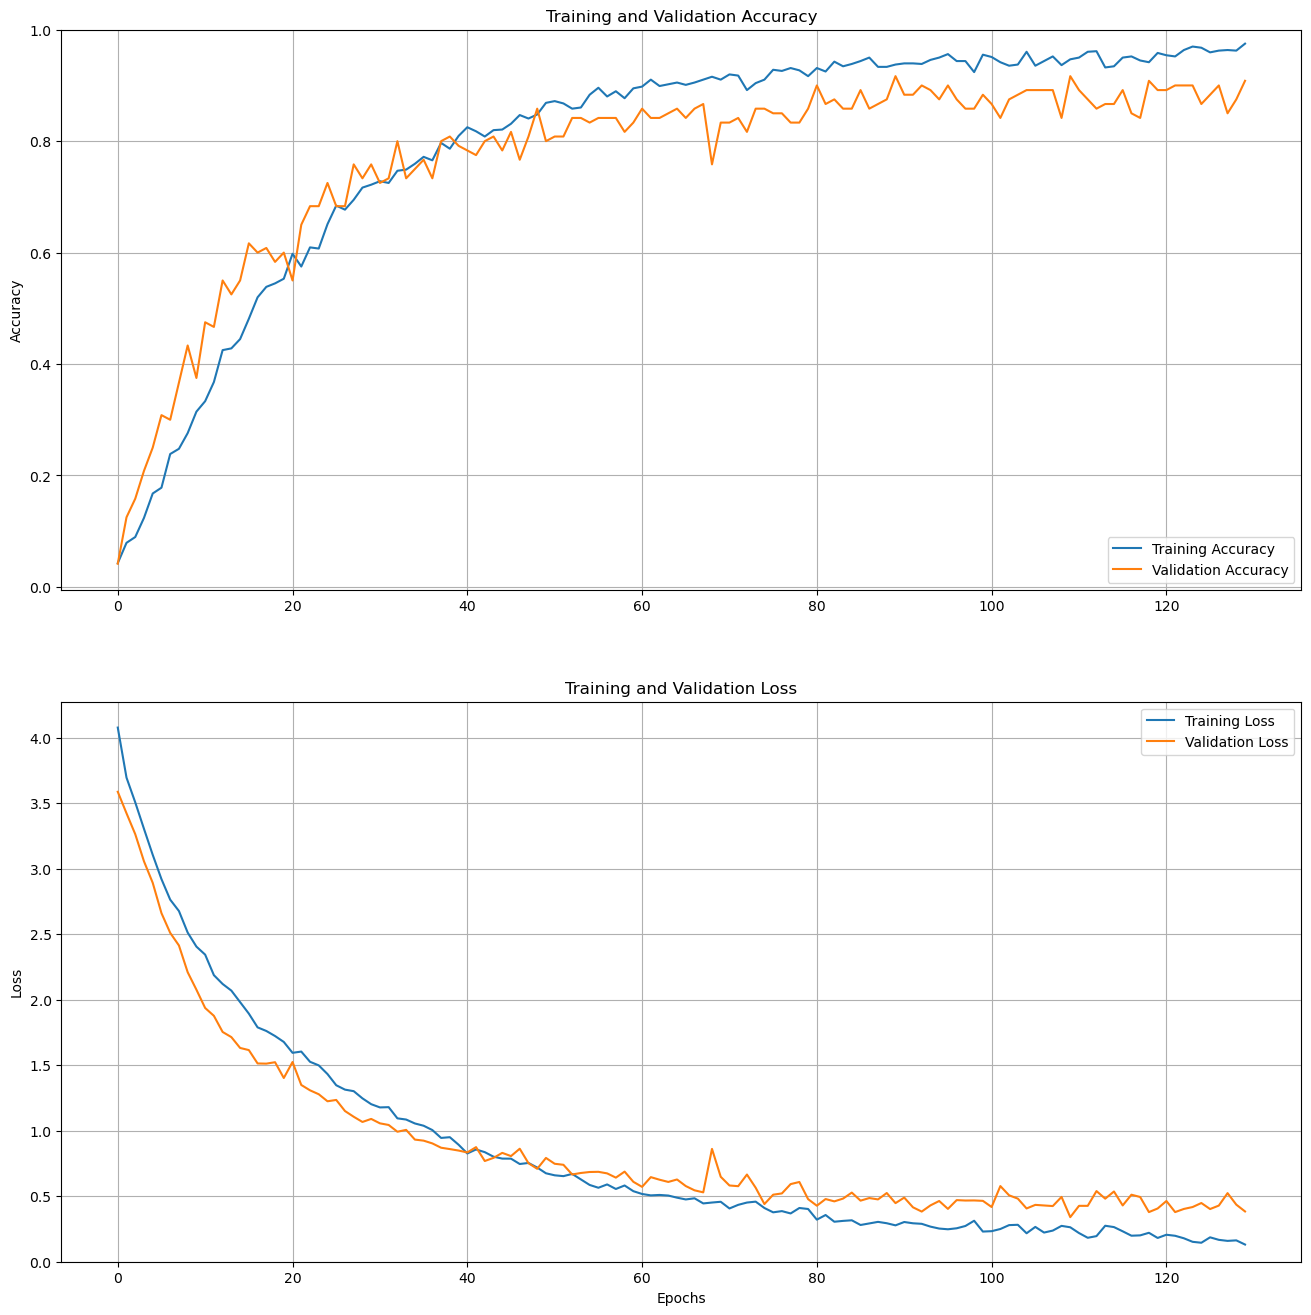

In [119]:
# The accuracy
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.grid()
plt.title('Training and Validation Accuracy')

# The loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0, max(plt.ylim())])
plt.grid()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

## Draw confusion matrix

4/4 [==============================] - 0s 54ms/step


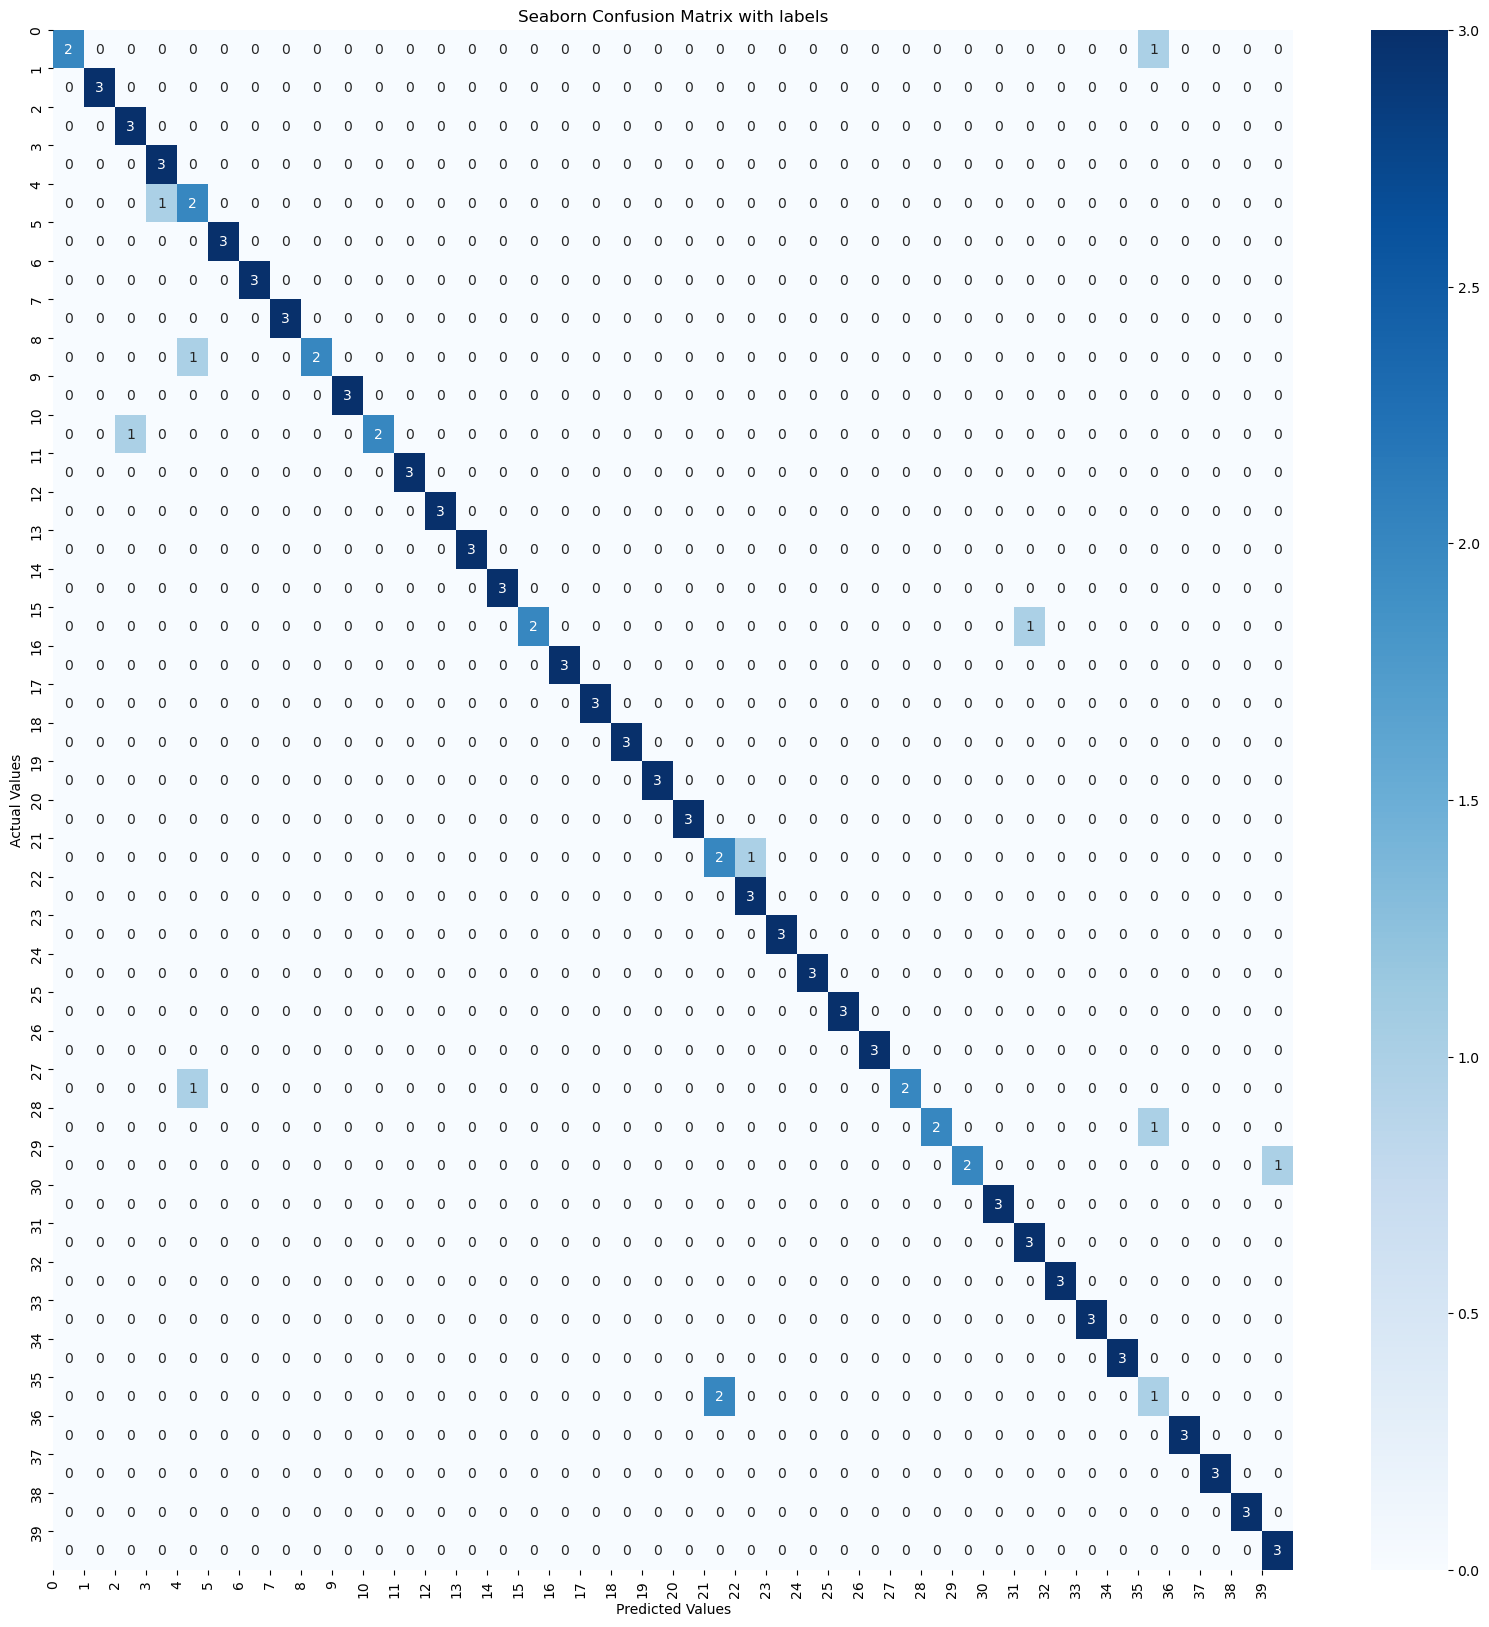

In [121]:
# Use the model to predict on your test data
y_preds = np.argmax(model.predict(test_data), axis=1)

cf_matrix = confusion_matrix(test_labels, y_preds)

# Create a heatmap
plt.figure(figsize=(20, 20))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Seaborn Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')


unique_labels = np.unique(np.concatenate((test_labels, y_preds)))
tick_labels = [str(label) for label in unique_labels]
tick_locations = np.arange(len(tick_labels))


ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels, rotation=90)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)


plt.show()

## Classification report

In [122]:
# y_true and y_pred are your true and predicted labels
report = classification_report(test_labels, y_preds, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
0,1.000000,0.666667,0.800000,3.000000
1,1.000000,1.000000,1.000000,3.000000
2,0.750000,1.000000,0.857143,3.000000
3,0.750000,1.000000,0.857143,3.000000
4,0.500000,0.666667,0.571429,3.000000
5,1.000000,1.000000,1.000000,3.000000
6,1.000000,1.000000,1.000000,3.000000
7,1.000000,1.000000,1.000000,3.000000
8,1.000000,0.666667,0.800000,3.000000
9,1.000000,1.000000,1.000000,3.000000
